In [ ]:
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from sklearn.metrics.cluster import adjusted_rand_score

import statistics

%matplotlib inline

In [ ]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content}

In [ ]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False, circles=None):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)
    G = list(G.subgraph(c) for c in nx.connected_components(G))[0]
    sum_list, labels, modularity, isolates = local_summaries_v2(G)
    # (a)
    nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes(labels, G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)
    plt.show()
    if circles:
        nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes([set(item) for item in circles.values()],G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)


    # (b)
    if directed:
        in_degree_sequence = [item[-2] for item in local_summaries_v2(G)[0]]
        in_degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()

        out_degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        out_degree_counts = Counter(out_degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()

        reciprocity_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        reciprocity_counts = Counter(reciprocity_sequence)
        fig, ax = plt.subplots()
        ax.bar(reciprocity_counts.keys(), reciprocity_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of Reciprocity')
        fig.tight_layout()
        plt.show()
    else:
        degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show()
    # (c)
    betweenness_centrality = [item[0] for item in local_summaries_v2(G)[0]]
    fig1, ax1 = plt.subplots()
    ax1.hist(betweenness_centrality)
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()
    # (d)
    eigenvector_centrality = [item[1] for item in local_summaries_v2(G)[0]]
    fig2, ax2 = plt.subplots()
    ax2.hist(eigenvector_centrality)
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()
    # Print Global Summaries
    global_summaries(G)
    print("Modularity : ", modularity)
    return labels

In [ ]:
def colorize_nodes(labels, G):
    final = [(0,0,0) for i in range(len(G.nodes()))]
    colors = [(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]) for i in range(len(labels))]

    for j,n in enumerate(G.nodes()):
        for i,label in enumerate(labels):
            if n in label:
                final[j]=colors[i]
    return final

In [ ]:
def local_summaries_v2(G, directed=False):

    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    max_betweenness_centrality_node = max(betweenness_centrality, key=betweenness_centrality.get)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    max_eigenvector_centrality = max(eigenvector_centrality, key=eigenvector_centrality.get)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    max_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)

    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        in_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_in_degree = max(max_in_degree, key=max_in_degree.get)
        out_degrees = [G.in_degree(n) for n in G.nodes]
        out_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_out_degree = max(out_degree_dict, key=out_degree_dict.get)
        reciprocity = nx.algorithms.reciprocity(G)
        mean_reciprocity = [value for key,value in nx.algorithms.reciprocity(G)].mean()
        return zip(betweenness_centrality.values(),
                   eigenvector_centrality.values(),
                   closeness_centrality.values(),
                   in_degrees,
                   out_degrees,
                   reciprocity,
                   nx.clustering(G)), max_betweenness_centrality_node, max_eigenvector_centrality, max_closeness_centrality, max_in_degree, max_out_degree, mean_reciprocity, nx.algorithms.isolate.number_of_isolates(G)
    else:
        degrees =[G.degree(n) for n in G.nodes]
        partitions = list(nx.algorithms.community.centrality.girvan_newman(G))
        mod_scores = [nx.community.quality.modularity(G, partition) for partition in partitions]
        maximum_modularity_score = max(mod_scores)
        best_partition = partitions[mod_scores.index(maximum_modularity_score)]
        return zip(betweenness_centrality.values(),
                   eigenvector_centrality.values(),
                   closeness_centrality.values(),
                   degrees,
                   nx.clustering(G)), best_partition,  maximum_modularity_score ,nx.algorithms.isolate.number_of_isolates(G)

In [ ]:
G = nx.read_edgelist('0.edges', nodetype=int)

In [ ]:
circles = read_circles("0.circles")

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


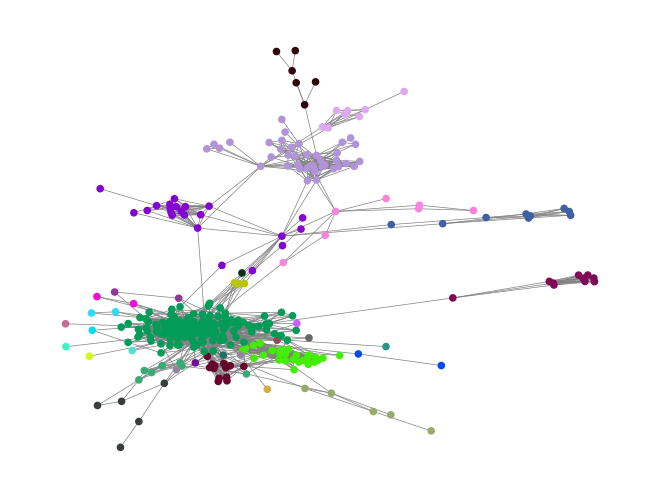

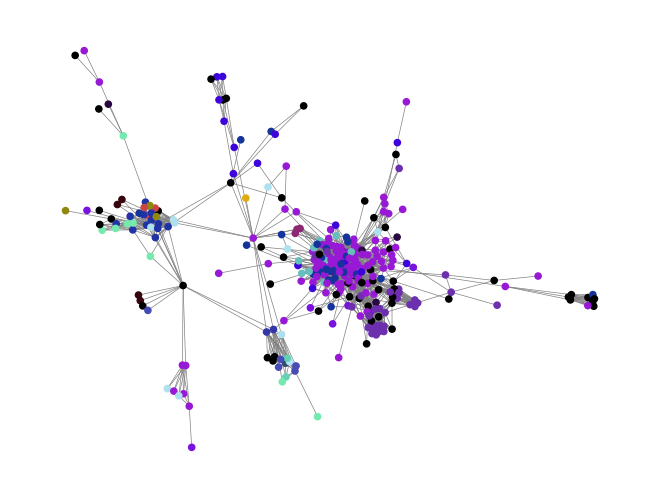

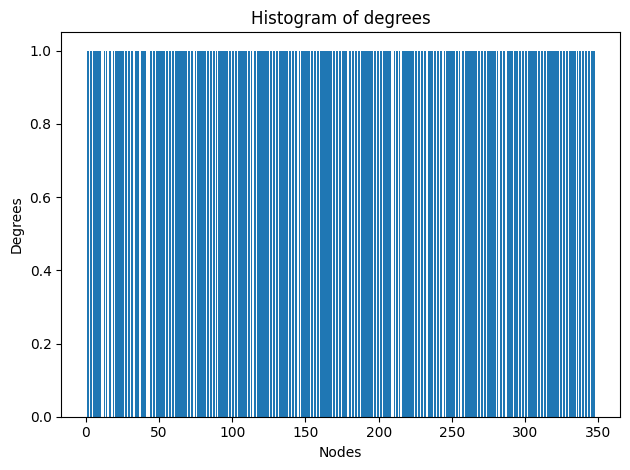

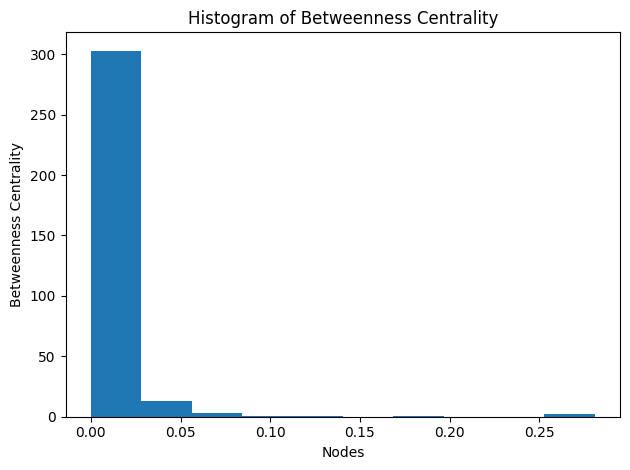

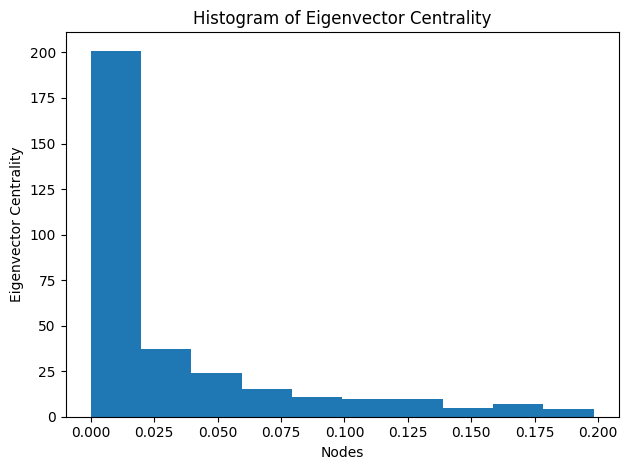

NameError: name 'global_summaries' is not defined

In [ ]:
lab = explore_and_summarize_network(edgelist = G.edges(), vertices=G.nodes(), subgraph=None, circles=circles)